# XAUUSD

In [1]:
import quandl
import pandas as pd
import numpy as np

# plotting modules
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm
import os

import warnings
import logging

# scikit-learn modules
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression

# User defined modules
from column_transformers.technical_indicators import MacdSignal, StochRsiSignal
from column_transformers.dates import DateDummy

In [2]:
xau_ratios = [
    "WGC/GOLD_DAILY_USD"
#     "WGC/GOLD_DAILY_EUR",
#     "WGC/GOLD_DAILY_TRY",
#     "WGC/GOLD_DAILY_JPY",
#     "WGC/GOLD_DAILY_GBP",
#     "WGC/GOLD_DAILY_CAD",
#     "WGC/GOLD_DAILY_CHF",
#     "WGC/GOLD_DAILY_VND",
#     "WGC/GOLD_DAILY_KRW",
#     "WGC/GOLD_DAILY_RUB",
#     "WGC/GOLD_DAILY_AUD",
]

economic_indc = []

### Quandl data terms

Anyone seeking to use this code must first apply for an account with [Quandl](https://www.quandl.com) in order to receive an valid authetitciation key.

In [3]:
DIR_NAME = os.path.abspath(os.path.join(os.getcwd(), '..'))
FILEPATH = os.path.join(DIR_NAME, "auth.txt")

with open(FILEPATH, "r") as f:
    authtoken = f.read();

# Retrieve Data

In [4]:
xau_df_dict = {}

for ratio in tqdm(xau_ratios):
    name = ratio.lower().replace("/", "_")

    # get the ratio dataframe
    df = quandl.get(ratio, authtoken=authtoken, start_date = "1979-01-01")
    df.columns = ["price"]
    
    # check for missing business days 
    if pd.infer_freq(df.index) != "B":
        logging.warn("Datetime frequency is not Business Days")
    
    xau_df_dict[name] = df

100%|██████████| 1/1 [00:02<00:00,  2.99s/it]


## Volatility

In [5]:
annualization_factor = 252.
window_size = [5, 10, 20, 60, 120]

for ratio, df in tqdm(xau_df_dict.items()):
    start_date, end_date = df.index[0], df.index[-1]
    full_range = pd.date_range(start_date, end_date, freq = "B")
    
    if not np.array_equal(df.index, pd.date_range(start_date, end_date, freq="B")):
        logging.warning("\n{} is missing business days".format(ratio))

    for window in window_size:
        df['{}d_market_vol'.format(window)] = np.sqrt(
            (annualization_factor/window) * df['price'].rolling(window).var(ddof=0))

100%|██████████| 1/1 [00:00<00:00,  2.18it/s]


## Quandl Features

In [6]:
features = [
    "FRED/T10Y2Y",
    "RATEINF/INFLATION_USA",
]

In [7]:
for ratio, df in xau_df_dict.items():
    for feature in features:
        col_name = feature.lower().replace('/', '_')
        
        # get quandl features. `end_date` is set to df.index[-1] to match the price data
        data = quandl.get(feature, authtoken=authtoken, start_date = "1979-01-01", end_date = df.index[-1])
        start_date, end_date = data.index[0], data.index[-1]

        # Some features contain missing data. To best simulate how the data would be ingested
        # realtime, the current value is forward filled. This achieved by resampling.
        if not np.array_equal(data.index, pd.date_range(start_date, end_date, freq="B")):
            logging.warning("\n\t{} is missing business days".format(feature))
                    
        df[col_name] = data
    
    df[:] = df.ffill()

	FRED/T10Y2Y is missing business days
	RATEINF/INFLATION_USA is missing business days


## Technical indicator features

In [15]:
import talib

technical_indicators= {
    "MACD" : ("macd", "macdsignal", "macdhist"),
    "STOCHRSI" : ("fastk", "fastd"),
    "MOM" : ("real"),
    "APO" : ('real'),
    "RSI" : ('real')
}

for ratio, df in xau_df_dict.items():
    
    # talib requires market price data. starting price of $1 is taken
    # since absolute values are not important (preprocess scaling)
    price = df['price'].values

    for indicator, indicator_type in technical_indicators.items():
        # Return the result for each indicator
        if indicator == 'STOCHRSI':
            result = getattr(talib, indicator)(price, fastd_matype = 8)
        else:
            result = getattr(talib, indicator)(price)

        if isinstance(result, np.ndarray):
            df[indicator.lower()] = result
        else:
            for f, r in zip(indicator_type, result):
                if f == indicator.lower():
                    df["{}".format(indicator.lower())] = r
                else:
                    df["{}_{}".format(indicator.lower(), f)] = r

## Data preprocessing 

In [9]:
from split._split import TrainValidateTest

data = xau_df_dict['wgc_gold_daily_usd']
data['target'] = data['price'].shift(-1).pct_change()
data.dropna(inplace = True)

X = data.drop(['price', 'target'], axis = 1)
y = (data['target'] > 0).astype(int)
    
split = TrainValidateTest(0.7, 0.15, 0.15)
X_train, X_valid,  X_test, y_train, y_valid,  y_test = split.transform(X, y)

df = data.loc['1980':'1981', ['price', 'macd', 'macd_macdsignal']]

/home/joepy/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1494: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [11]:

X = xau_df_dict['wgc_gold_daily_usd']['price'].copy()
#macd = MacdStrategy()
#d = macd.fit_transform(X)


In [12]:
class MacdStrategy(BaseEstimator, TransformerMixin):
    """
    Stores the parameters to constrain a moving average convergence/
    divergence (MACD) momentum based strategy. The indicator consists of
    three components (the 'macd series', the 'average series' of the macd 
    series and the 'divergence'). The 'macd series' is the difference
    between a 'fast' exponential moving average (EMA) and a 'slow' EMA. 
    The speed refers to the period of the EMA. The 'average series' is an 
    EMA of the 'macd series'. The 'divergence' is the difference between 
    these two series. 
    
    Parameters
    ----------
    result : str or int, default 'optimal'
    fast_period : float, default 12.
        Time constant for the 'fast' price series exponential moving average
    slow_period : float, default 26.
        Time constant for the 'slow' price series exponential moving average 
    signal_period : float, default 9.
        Time constant for the macd series exponential moving average  
        
    Examples
    --------
    Constructing a MacdStrategy using the default values
    
    >>> strategy = MacdStrategy()
    
    """
    
    # ======================================================================
    # Constants
    # ======================================================================
    
    PRICE, MACD, MACD_SIGNAL, MACD_HIST, RATIO = 0, 1, 2, 3, 3
    
    # ======================================================================
    # Constructors
    # ======================================================================

    def __init__(self, 
                 result = 'optimal',
                 fast_period=12.0, 
                 slow_period=26.0, 
                 signal_period=9.0):
        
        
        if result == 'optimal':
            self.optimal_result = True
            self.optimal_parameters = 0
        elif isinstance(result, (int, float)):
            self.optimal_result = False
            self.optimal_parameters = np.zeros([int(result), 4])
        else:
            raise ValueError(
                "'result' must be either a valid string or an int/float ")
        
        # set default model parameters if user wishes to use self.transform
        # with experimental parameters
        self.fast_period = fast_period
        self.slow_period = slow_period
        self.signal_period = signal_period
        
        # set reasonable test time constants
        self.fast_period_test = np.arange(2,20, dtype = float)
        self.slow_period_test = np.arange(3, 30, dtype = float)
        self.signal_period_test = np.arange(4, 15, dtype = float)
        
        
        
        
    # ======================================================================
    # Rendering Methods
    # ======================================================================

        
    def __repr__(self):
        return "TBD"
    
    
    # ======================================================================
    # strategy statistics/signals
    # ======================================================================
    
    def _macd(self,
              X = None,
              fast_period = None, 
              slow_period = None, 
              signal_period = None, 
              column_name='price'):
        """
        Two-dimensional tabular data structure containing a price series and 
        claculated macd time series.
        
        Parameters
        ----------
        X : pd.DataFrame or pd.Series
             DataFrame or Series containing the price time series for a 
             single asset
        column_name : str, default price
            The name of the column containing the price time series data
            
        Returns
        -------
        X_macd : pd.DataFrame
            Returns a DataFrame consisting of the original price time
            series and the calculated macd time series data
          
        """
        
        # determine if default macd quantities shoud be used
        if fast_period is None:
            fast_period = self.fast_period
        if slow_period is None:
            slow_period = self.slow_period
        if signal_period is None:
            signal_period = self.signal_period
            
            
        if not isinstance(column_name, str):
            raise TypeError("'column_name' must be of type str")

            
        if not isinstance(X, (pd.DataFrame, pd.Series)):
            raise TypeError("'X' must be of type pd.DataFrame or pd.Series")            
        elif isinstance(X, pd.DataFrame):
            price_series = X[column_name].values
        elif isinstance(X, pd.Series):
            price_series = X.values
            
        # returns a tuple of macd, macd_signal and mach_hist
        macd_statistics = talib.MACD(
            price_series,
            fastperiod = fast_period,
            slowperiod = slow_period,
            signalperiod = signal_period
        )    
        
        price_macd = np.c_[price_series, np.array(macd_statistics).T]
        
        return price_macd[~np.isnan(price_macd).any(1), :]

            
    def _long_signal(self, price_macd):
        long = price_macd[:, self.MACD] > price_macd[:, self.MACD_SIGNAL]
        
        return long[:-1] * 1
    
    
    def _short_signal(self, price_macd):
        short = price_macd[:, self.MACD] < price_macd[:, self.MACD_SIGNAL]
       
        return short[:-1] * -1
    
    
    def _asset_returns(self, price_macd):
        return (
            np.diff(price_macd[:, self.PRICE]) / price_macd[:-1, self.PRICE]
        )
    
    
    def _strategy_returns(self, price_macd):
        
        # generate strategy long/short signal and asset returns
        long_signal = self._long_signal(price_macd)
        short_signal = self._short_signal(price_macd)
        
        # calculate the assets simple returns 
        asset_returns = self._asset_returns(price_macd)
        
        return (asset_returns * long_signal) + (asset_returns * short_signal)

   
    # ======================================================================
    # Parameter estimation
    # ======================================================================

    
    def _cost_function(self, 
                       strategy_returns, 
                       annualisation_factor, 
                       risk_free_rate):
        
        excess_return = (
            (np.sqrt(annualisation_factor) * strategy_returns.mean()) - risk_free_rate
        )
        
        return excess_return / returns.std()
    
    
    def _fit(self, X, y, annualisation_factor, risk_free_rate):
        
        for f in tqdm(self.fast_period_test):
            for s in self.slow_period_test:
                for p in self.signal_period_test:
                    
                    price_macd = self._macd(X, f, s, p)
                    strategy_returns = self._strategy_returns(price_macd)
                    
                    ratio = self._cost_function(
                            strategy_returns,
                            annualisation_factor,
                            risk_free_rate
                        )
                    
                    if self.optimal_result:
                        if ratio > self.optimal_ratio:
                            self.ratio = ratio
                            self.fast_period = f
                            self.slow_period = s
                            self.signal_period = p
                    else:
                        argmin = self.optimal_parameters[:, self.RATIO].argmin()
                        
                        if ratio > self.optimal_parameters[argmin, self.RATIO]:
                            self.optimal_parameters[argmin] = [
                                f, s, p, ratio
                            ]
                        
        
    # ======================================================================
    # Public methods
    # ======================================================================
    
    
    def fit(self, X, y=None, annualisation_factor=252, risk_free_rate=0.00):
        
        self._fit(X, y, annualisation_factor, risk_free_rate)
        return self 
        
        
    def transform(self, X, y=None, as_frame=False):
        """
        Transform the asset price series into a return time series using the 
        predefined macd momentum based strategy. 
        
        Parameters
        ----------
        X : pd.DataFrame or pd.Series
            DataFrame or Series containing the price time series for a 
            single asset 
        y : pd.DataFrame or pd.Series, default None
            DataFrame or Series containing the price time series for a 
            single asset
            
        Returns
        -------
        X_macd :  X_macd : pd.DataFrame
            Returns a DataFrame consisting of the original price time
            series, calculated macd time series data and strategy returns
            
        Examples
        --------
        
        >>> X 
                      price
        Date	
        1979-06-15	 280.00
        1979-06-18	 278.00
        1979-06-19	 280.30
        1979-06-20	 281.35
        1979-06-21	 282.30
        1979-06-22	 283.45
        
        
        >>> strategy = MacdStrategy()
        >>> strategy.transform(X)
        
                    price  macd  macd_signal     ...  macd_strategy_returns
        Date					
        1979-06-15	  280   NaN	         NaN	 ...	                NaN
        ...           ...   ...          ...     ...                    ...
        1979-08-02	  291	4.07	     6.20	 ...	          -0.004826
        1979-08-03	  287	2.93         5.55	 ...	           0.017153
        1979-08-06	  283	1.70	    4.779	 ...	           0.013264
        
        """
        
        price_macd = self._macd(X)
        
        index_size = X.index.size
        new_index = X.index[(index_size) - price_macd.shape[0]:]
        
        price_macd_df = pd.DataFrame(price_macd, index = new_index)
        asset_returns = np.insert(self._strategy_returns(price_macd), 0, np.nan)
      
        price_macd_df['macd_strategy_returns'] = (
            asset_returns
        )
        
        return price_macd_df
    
s = MacdStrategy(result = 10)
# s.fit(X)
# s.optimal_parameters



In [ ]:

        
        
talib.STOCHRSI()

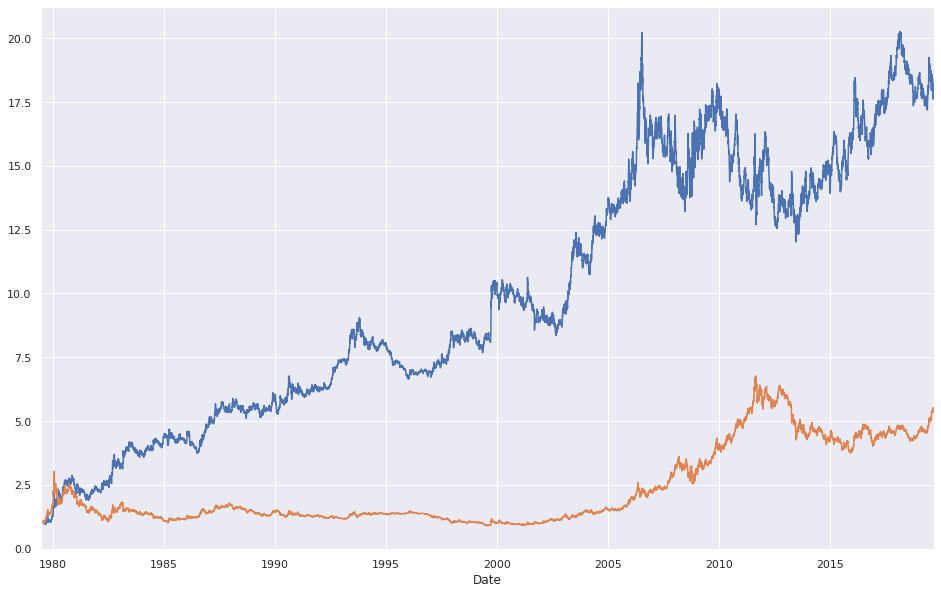

In [30]:
s = MacdStrategy(fast_period=11, slow_period=29, signal_period=12)
(1 + s.transform(X)['macd_strategy_returns'].dropna()).cumprod().plot()
(X/X[0]).plot()

In [120]:
X_rsi = xau_df_dict['wgc_gold_daily_usd'][['price','rsi']]


sns.set(rc={'figure.figsize':(16, 10)})

rsi_min = X_rsi['rsi'].rolling(14).min()
rsi_max = X_rsi['rsi'].rolling(14).max()

X_rsi['stoch_rsi_k'] = (((X_rsi['rsi'] - rsi_min) / (rsi_max - rsi_min)).rolling(3).mean() * 100)
X_rsi['stoch_rsi_d'] = X_rsi['stoch_rsi_k'].rolling(3).mean()

X_rsi = X_rsi.dropna()

/home/joepy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/home/joepy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


In [235]:
X_rsi['long'] = (
    ((X_rsi['stoch_rsi_k'].shift(1) > 20)) |#& (X_rsi['stoch_rsi_k'].shift(2) < X_rsi['stoch_rsi_k'].shift(1))) | 
    (X_rsi['stoch_rsi_k'].shift(1) > 70)
) * 1

X_rsi['short'] = (
    ((X_rsi['stoch_rsi_k'].shift(1) < 45) & (X_rsi['stoch_rsi_k'].shift(2) > X_rsi['stoch_rsi_k']).shift(1)) | 
    (X_rsi['stoch_rsi_k'].shift(1) < 5)
) * -1

# fig, axes = plt.subplots(nrows=2, ncols=1)
# X_rsi.loc['2016', 'price'].plot(ax = axes[0])
# X_rsi.loc['2016', 'stoch_rsi_k'].plot(ax=axes[1])

longs = X_rsi.index[X_rsi['long'] == 1]
shorts = X_rsi.index[X_rsi['short'] == -1]

# start date positions of new long/short positions
long_indices_or_sections = np.arange(longs.size)[longs.to_series().diff() > pd.Timedelta('3D')]
short_indices_or_sections = np.arange(shorts.size)[shorts.to_series().diff() > pd.Timedelta('3D')]

long_date_regions = np.split(longs, long_indices_or_sections)
short_date_regions = np.split(shorts, short_indices_or_sections)

# for l_period, s_period in zip(long_date_regions, short_date_regions):
#     for ax in axes:
#         ax.axvline(l_period[0], color='green', linewidth=1)
#         ax.axvline(s_period[0], color='green', linewidth=1)
                                             
#         ax.axvline(l_period[-1], color='red', linewidth=1)
#         ax.axvline(s_period[-1], color='red', linewidth=1)

#         ax.axvspan(l_period[0], l_period[-1], alpha = 0.1, color = 'green')
#         ax.axvspan(s_period[0], s_period[-1], alpha = 0.1, color = 'red')
        
#         if ax == axes[-1]:
#             ax.axhline(80, color='blue', linewidth=1)
#             ax.axhline(20, color='blue', linewidth=1)

X_rsi['returns'] = X_rsi['price'].pct_change()

In [170]:
class StochasticRsi():
    def __init__(self, real, timeperiod=14, k=3, d=3, sma=True):
        self.real = real
        self.timeperiod = timeperiod
        self.k = k
        self.d = d
        
    def 

,price,rsi,stoch_rsi_k,stoch_rsi_d,long,short,returns,strategy,perf
Date,,,,,,,,,
2019-09-09,1509.20,52.602764,1.480297e-13,2.196724e+01,0,-1,-0.009516,0.009516,1.396962
2019-09-10,1498.25,48.274016,1.480297e-13,8.060390e+00,0,-1,-0.007255,0.007255,1.407098
2019-09-11,1490.65,45.476789,1.480297e-13,1.989520e-13,0,-1,-0.005073,0.005073,1.414235
2019-09-12,1515.20,54.623551,1.069945e+01,3.566485e+00,0,-1,0.016469,-0.016469,1.390944
2019-09-13,1503.10,50.157342,1.617455e+01,8.958000e+00,0,-1,-0.007986,0.007986,1.402051


0.47883233124573066


(<matplotlib.axes._subplots.AxesSubplot at 0x7f91f5a4a4a8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f91f5a4a4a8>)

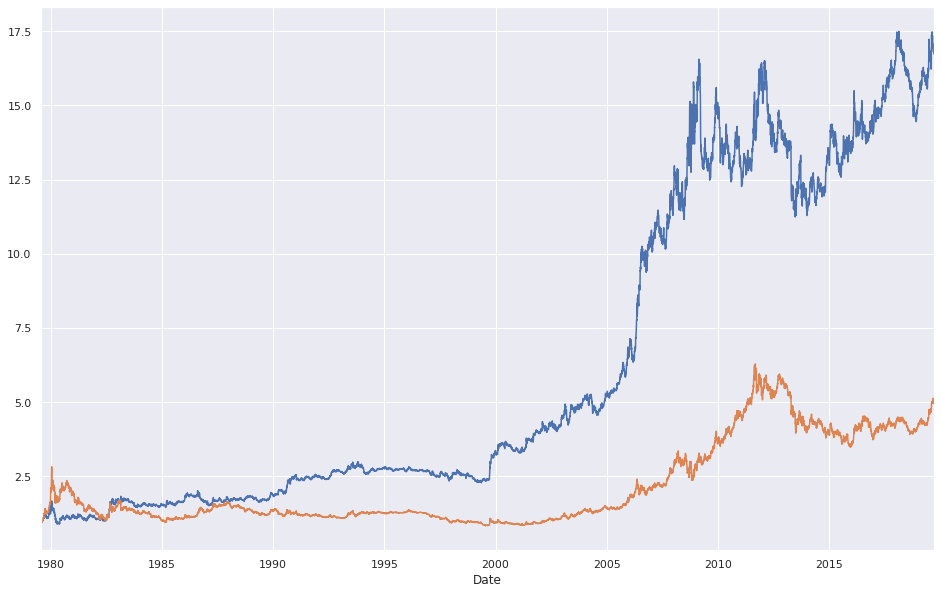

In [236]:
X_rsi['strategy'] = (X_rsi['returns'] * X_rsi['long']) + (X_rsi['returns'] * X_rsi['short'])

X_rsi['perf'] = (1 + X_rsi['strategy']).cumprod()

print((np.sqrt(252.) * X_rsi['strategy'].mean()) / X_rsi['strategy'].std())

(X_rsi['perf'][-1] ** (252/X_rsi.index.size)) - 1#

(X_rsi['perf']).plot(), (X_rsi['price'] / X_rsi['price'][0]).plot()

In [ ]:
df = data.loc[:, ['price', 'macd', 'macd_macdsignal']]

# Calculate the returns
df['returns'] = df['price'].pct_change()

# long/short periods ignoring lookahead bias
long_biased = df['macd'] >= df['macd_macdsignal']
short_biased = (df['macd'] <= df['macd_macdsignal'])

# Define long entry and exit points
long_entry = (df['macd'].shift(1) > df['macd_macdsignal'].shift(1)) #& (df['macd'].diff() > 0 & (df['macd'].diff().shift(1) < 0))
#cross_over_long_exit = (df['macd'] < df['macd_macdsignal']) & (df['macd'].shift(1) > df['macd_macdsignal'].shift(1))
#omentum_long_exit = (df['macd'].diff() >= 0) & (df['macd'].diff().shift(1) <= 0)

# Define short entry and exit points
short_entry = (df['macd'].shift(1) < df['macd_macdsignal'].shift(1)) & ((df['macd'].diff().shift(1) < 0))
#cross_over_short_exit = (df['macd'] > df['macd_macdsignal']) & (df['macd'].shift(1) < df['macd_macdsignal'].shift(1))
#momentum_short_exit = (df['macd'].diff() <= 0) & (df['macd'].diff().shift(1) <= 0)

# define simple long/short strategy
df['long'] = (long_entry) * 1 # add exit periods back here
df['short'] = (short_entry) * -1

# long/short periods
longs = df.index[df['long'] == 1]
shorts = df.index[df['short'] == -1]

# start date positions of new long/short positions
long_indices_or_sections = np.arange(longs.size)[longs.to_series().diff() > pd.Timedelta('3D')]
short_indices_or_sections = np.arange(shorts.size)[shorts.to_series().diff() > pd.Timedelta('3D')]

# long/short date regions
long_date_regions = np.split(longs, long_indices_or_sections)
short_date_regions = np.split(shorts, short_indices_or_sections)


df['alpha_return'] = (df['returns'] * df['long']) + (df['returns'] * df['short']) 
df['gold_perf'] =  (1 + df['returns']).cumprod()
df['alpha_perf'] = (1 + df['alpha_return']).cumprod()

#df = df.dropna()

print((np.sqrt(252.) * df['alpha_return'].mean()) / df['alpha_return'].std())

df[['alpha_perf', 'gold_perf']].plot()

In [ ]:
d = d.dropna()

In [ ]:
d.head()

In [ ]:
sns.set(rc={'figure.figsize':(16, 10)})
fig, axes = plt.subplots(nrows=3, ncols=1)

df.loc['1990', 'alpha_perf'].plot(ax = axes[0])
df.loc['1990', ['macd', 'macd_macdsignal']].plot(ax=axes[1])
df.loc['1990', 'gold_perf'].plot(ax = axes[2])

for l_period, s_period in zip(long_date_regions, short_date_regions):
    for ax in axes:
        ax.axvline(l_period[0], color='green', linewidth=1)
        ax.axvline(s_period[0], color='green', linewidth=1)
                                             
        ax.axvline(l_period[-1], color='red', linewidth=1)
        ax.axvline(s_period[-1], color='red', linewidth=1)

        ax.axvspan(l_period[0], l_period[-1], alpha = 0.1, color = 'green')
        ax.axvspan(s_period[0], s_period[-1], alpha = 0.1, color = 'red')

In [ ]:
preprocess_pipeline = Pipeline([
     ('macd_ud_signal', MacdSignal()),
     ('stoch_ud_signal', StochRsiSignal()),
     #('date', DateDummy('weekday_name', 'month_name')),
     #('vol_diff', VolatilityDiff()),
     #('scalar', StandardScaler())
])

X_train_trans, X_valid_trans= (
    preprocess_pipeline.fit_transform(X_train),
    preprocess_pipeline.transform(X_valid)
)

X_train_trans.head()

In [ ]:
sns.set(rc={'figure.figsize':(15, 8)})
df = X_train.loc['1981', ['10d_market_vol', '20d_market_vol']]

d_20 = df['10d_market_vol']
d_60 = df['20d_market_vol']

df.plot()

dates = (
    (d_20 > d_60) & (d_20.shift(-1) < d_60.shift(-1)) |
    (d_20 > d_60) & (d_20.shift(1) < d_60.shift(1))
)

for date in d_20.index[dates]:
    plt.axvline(date)
    difference = (d_20 -d_60)

difference.index[(difference < 0) & (difference.shift(-1) > 0)]
difference.plot()

xau_df_dict['wgc_gold_daily_usd'].loc['1981', 'price'].plot()
for date in d_20.index[dates]:
    plt.axvline(date)

## Model Selection

In [ ]:

classifiers = [
    SVC(gamma=2, C=1),
    LogisticRegression(),
    RandomForestClassifier(criterion='entropy', oob_score=True, n_jobs=-1, random_state= 0),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GradientBoostingClassifier(n_estimators=100),
]

In [ ]:
results = {}

for clf in tqdm(classifiers, unit='Model') :
    clf.fit(X_train_trans, y_train)
    
    name = str(clf).split('(')[0]
    
    results[name] = {
        "train_score" : clf.score(X_train_trans, y_train),  
        "valid_score" : clf.score(X_valid_trans, y_valid)
    }      
    
results

## Model Evaluation

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits = 2)
clf =  RandomForestClassifier(criterion='entropy', oob_score=True, n_jobs=-1, random_state= 0)
rf_param_grid = {
    'max_depth': [25, 30],
    'min_samples_leaf': [10, 15, 16],
    'min_samples_split': [2, 5],
    'n_estimators': [50, 100, 150]
}

search = GridSearchCV(estimator=clf, cv=tscv, param_grid=rf_param_grid)
search.fit(X_train_trans, y_train)

In [ ]:
search.score(X_train_trans, y_train), search.score(X_valid_trans, y_valid)
search.best_params_

In [ ]:
train_score

In [ ]:
n_days = X_train.shape[0]
n_features = X_train.shape[1]

clf_parameters = {
    'criterion': 'entropy',
    'min_samples_leaf': 15,
    'max_depth' : 25,
     'min_samples_split': 8,
    'oob_score': True,
    'n_jobs': -1,
    'random_state': 0}

n_trees_l = [75, 100, 150, 300]

In [ ]:
train_score = []
valid_score = []
oob_score = []
feature_importances = []

for n_trees in tqdm(n_trees_l, desc='Training Models', unit='Model'):
    
    clf = RandomForestClassifier(**search.best_params_)
    clf.fit(X_train_trans, y_train)
    
    train_score.append(clf.score(X_train_trans, y_train))
    valid_score.append(clf.score(X_valid_trans, y_valid))
    
#     oob_score.append(clf.oob_score_)
#     feature_importances.append(clf.feature_importances_)

In [ ]:
train_score, valid_score


In [ ]:
def plot(xs, ys, labels, title='', x_label='', y_label=''):
    for x, y, label in zip(xs, ys, labels):
        plt.ylim((0.3, 0.9))
        plt.plot(x, y, label=label)
        
    plt.title(title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)

    plt.legend(bbox_to_anchor=(1.04, 1), borderaxespad=0)
    plt.show()

plot([n_trees_l]*3,
    [train_score, valid_score, oob_score],
    ['train', 'validation', 'oob'],
    'Random Forrest Accuracy',
    'Number of Trees')

In [ ]:
prob_array=[-1,1]
alpha_score = clf.predict_proba(X_train_trans).dot(np.array(prob_array))

# calculate daily returns
alpha_return = alpha_score * data.loc[X_train.index, 'target'].shift(-1) 

xau_usd_return = data.loc[X_train.index, 'target']

# calculate cumulative performance
alpha_perf = 100000 * ((1 + alpha_return).cumprod())
xau_usd_per = 100000 * ((1 + xau_usd_return).cumprod())

#alpha_return.plot()
alpha_sharpe = (np.sqrt(252.) * alpha_return.mean()) / alpha_return.std() 
xau_usd_sharpe = (np.sqrt(252.) * xau_usd_return.mean()) / xau_usd_return.std() 

alpha_perf.plot()
xau_usd_per.plot()

xau_usd_return.mean() / alpha_return.mean() 
sns.set(rc={'figure.figsize':(15, 8)})
plt.legend(labels = ['Model', 'Actual Gold/USD'])


print(alpha_sharpe, xau_usd_sharpe)
alpha_return.std() / xau_usd_return.std()

alpha_perf[-2] ** (252 / alpha_perf.size) - 1 

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes=np.linspace(.1, 1.0, 5)
estimator = RandomForestClassifier(**search.best_params_)
cv = TimeSeriesSplit(n_splits = 5)


In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

plot_learning_curve(estimator, "lol", X, y, n_jobs =4, cv =cv, train_sizes=train_sizes)

In [ ]:
#learning_curve(
        #estimator, X, y, cv=cv, n_jobs=4, train_sizes=train_sizes)
    
cv